# Lista 8 (10 pkt.)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, Mod

## Zadanie 1 (2 pkt.)

Napisz funkcję **gen(a,b,p)**, która generuje listę punktów reprezentujących krzywą eliptyczną nad $\mathbb{Z}_p$ o równaniu $y^2=(x^3+ax+b)\mod p$.

In [12]:
def gen(a,b,p):
    pairs = []
    for x in range(p):  # Iterate through all possible values of x modulo p
        rhs = (x**3 + a*x + b) % p  # Calculate the RHS of the equation
        for y in range(p):  # Iterate through all possible values of y modulo p
            if (y**2) % p == rhs:  # Check if y^2 ≡ RHS (mod p)
                pairs.append([x, y])  # Add the valid (x, y) pair
    return pairs
    


In [14]:
print(gen(-1,0,7)==[[0, 0], [1, 0], [4, 2], [4, 5], [5, 1], [5, 6], [6, 0]])
print(gen(-1,0,11)==[[0, 0], [1, 0], [4, 4], [4, 7], [6, 1], [6, 10], [8, 3], [8, 8], [9, 4], [9, 7], [10, 0]])
print(gen(-1,1,7)==[[0, 1], [0, 6], [1, 1], [1, 6], [2, 0], [3, 2], [3, 5], [5, 3], [5, 4], [6, 1], [6, 6]])
print(gen(0,2,5)==[[2, 0], [3, 2], [3, 3], [4, 1], [4, 4]])

True
True
True
True


## Zadanie 2 (2 pkt.)

Napisz funkcję **add(P,Q,a,p)**, która dodaje do siebie punkty $P$ i $Q$ na krzywej eliptycznej nad ciałem $\mathbb{Z}_p$ z parametrem $a$. Wykorzystaj wzory z wykładu.

$$x_3 = \left(s^2-x_1-x_2\right) \mod p$$
$$y_3 = \left(s\left(x_1-x_3\right)-y_1 \right) \mod p$$

$$s=\frac{y_2-y_1}{x_2-x_1} \mod p \quad P\neq Q$$
$$s=\frac{3x_1^2+a}{2y_1} \mod p \quad P=Q$$

$(x_3, y_3)$ to współrzędne punktu będącego sumą punktów $(x_1, y_1)$ i $(x_2, y_2)$. Natomiast $a$ to współczynnik z równania krzywej.

Uwaga 1: wszystkie operacje w tych wzorach są na ciele $\mathbb{Z}_p$ zatem tam gdzie mamy dzielenie mamy tak naprawdę mnożenie przez odwrotność w tym ciele, wykorzystaj tutaj funkcję **inv** z poprzedniej listy, może być potrzeba ją nieco zmodyfikować, ponieważ może się tu pojawić dzielenie przez zero, które daje nam punkt "w nieskończości" (na wykładzie: $\mathcal{O}$).

Uwaga 2: Uwzględnij również, że zarówno w wyniku dodawania jak i w argumentach dodawanie może pojawić się punkt "w nieskończoności", zwracaj go jako **nan**, tj. za pomocą **float('nan')**, do sprawdzania czy coś jest **nan** użyj **np.isnan()**.

In [18]:
def pow_mod(base,exponent,modulus):
    if modulus == 1:
        return 0
    # Ensure (modulus - 1) * (modulus - 1) does not overflow base
    # assert (modulus - 1) * (modulus - 1) <= base  # This ensures the condition

    result = 1
    base = base % modulus

    while exponent > 0:
        if exponent % 2 == 1:  # If the exponent is odd
            result = (result * base) % modulus
        exponent = exponent >> 1  # Equivalent to floor division by 2
        base = (base * base) % modulus
    
    return result

# gcd(a,b)=a⋅x+b⋅y
def extended_gcd(a, b):
    if b == 0:
        return a, 1, 0
    gcd, x1, y1 = extended_gcd(b, a % b)
    x = y1
    y = x1 - (a // b) * y1
    return gcd, x, y

def inv(p,n):
    gcd, x, _ = extended_gcd(p, n)
    if gcd != 1:
        raise ValueError(f"{p} has no modular inverse modulo {n}")
    return x % n

In [40]:
def add(P, Q, a, p):
    # Check if either P or Q is the point at infinity
    if np.isnan(P[0]) or np.isnan(P[1]):
        return Q
    if np.isnan(Q[0]) or np.isnan(Q[1]):
        return P

    x1, y1 = P
    x2, y2 = Q

    # Check if P == Q and 2y1 == 0 (vertical tangent line)
    if P == Q and y1 % p == 0:
        return [float('nan')]  # Result is the point at infinity

    # Calculate the slope s
    if P != Q:
        # P != Q case
        denominator = (x2 - x1) % p
        if denominator == 0:
            return [float('nan')]  # Division by zero, result is at infinity
        s = ((y2 - y1) * inv(denominator, p)) % p
    else:
        # P == Q case
        denominator = (2 * y1) % p
        if denominator == 0:
            return [float('nan')]  # Division by zero, result is at infinity
        s = ((3 * x1**2 + a) * inv(denominator, p)) % p

    # Compute x3 and y3
    x3 = (s**2 - x1 - x2) % p
    y3 = (s * (x1 - x3) - y1) % p

    return [x3, y3]

In [41]:
print(add([4,2],[5,1],-1,7)==[6,0])
print(add([4,2],[4,2],-1,7)==[1,0])
print(add([4,2],[5,1],-1,7)==[6,0])
print(add([4,2],[float('nan'),float('nan')],-1,7)==[4,2])
print(np.isnan(add([float('nan'),float('nan')],[float('nan'),float('nan')],-1,7)))
print(np.isnan(add([0,0],[0,0],-1,7)))
print(add([2,0],[3,2],0,5)==[4,1])
print(np.isnan(add([2,0],[2,0],0,5)))

True
True
True
True
[ True  True]
[ True]
True
[ True]


W oparciu o poprzednią funkcję napisz funkcję **multiply(n,P,a,p)**, która mnoży punkt $P$ razy liczbę naturalną $n$ na krzywej eliptycznej nad ciałem $\mathbb{Z}_p$ z parametrem $a$, tzn. dodaje ten punkt do siebie $n$ razy.

In [45]:
def multiply(n,P,a,p):
    result = P
    for _ in range(n-1):
        result = add(result,P,a,p)
    return result

In [47]:
print(multiply(1,[4,2],-1,7)==[4,2])
print(multiply(1,[4,2],-1,7)==[4,2])
print(multiply(3,[4,2],-1,7)==[4,5])
print(np.isnan(multiply(4,[4,2],-1,7)))
print(np.isnan(multiply(2,[float('nan'),float('nan')],-1,7)))
print(multiply(5,[2,0],0,5)==[2,0])
print(multiply(5,[3,3],0,5)==[3,2])

True
True
True
[ True]
[ True  True]
True
True


## Zadanie 3 (2 pkt.)

Narysuj na wykresie punkty (**plt.scatter()**) reprezentujące krzywą eliptyczną. Stosując funkcję **multiply()** przeanalizuj jaką grupę generuje każdy z punktów tej krzywej, wypisz te grupy. Nie automatyzuj tego, tzn. operacje na punktach wykonuj stosując wcześniejsze funkcje ale analizę poszczególnych grup przeprowadź ręcznie.

Na przykład dla krzywej $y^2=x^3-5x$ nad ciałem $\mathbb{Z}_5$ mamy 5 punktów (łącznie z punktem w nieskończoności, którego nie ma na wykresie, 6 punktów):

<img src="fig.png" width="500"/>

Punkt $P_0$ generuje dwuelementową grupę:

{$P_0,\mathcal{O}$},

bo $2P_0=\mathcal{O}$,

punkt $P_1$ generuje pięcioelementową grupę:

{$P_1,P_3,P_4,P_2,\mathcal{O}$}

bo $2P_1=P_3,3P_1=P_4,4P_1=P_2,5P_1=\mathcal{O}$

pozostałe elementy $P_2,P_3,P_4$ generują dokładnie tą samą grupę, zatem na tej krzywej mamy określone dwie grupy jedną dwuelementową i jedną pięcioelementową.

Przeprowadź podobną analizę dla przykładów:
1. krzywa nad ciałem $\mathbb{Z}_7$ o równaniu $y^2=x^3-x$
2. krzywa nad ciałem $\mathbb{Z}_5$ o równaniu $y^2=x^3-2x+1$

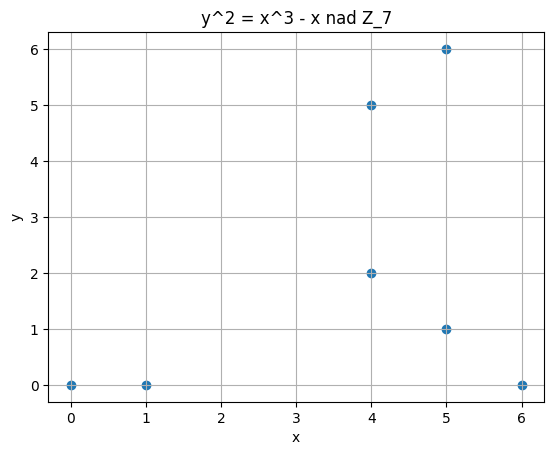

Analiza dla krzywej y^2 = x^3 - x nad Z_7
Punkt [0, 0] generuje grupę: [[0, 0], ['∞']], długość grupy: 2
Punkt [1, 0] generuje grupę: [[1, 0], ['∞']], długość grupy: 2
Punkt [4, 2] generuje grupę: [[4, 2], [1, 0], [4, 5], ['∞']], długość grupy: 4
Punkt [4, 5] generuje grupę: [[4, 5], [1, 0], [4, 2], ['∞']], długość grupy: 4
Punkt [5, 1] generuje grupę: [[5, 1], [1, 0], [5, 6], ['∞']], długość grupy: 4
Punkt [5, 6] generuje grupę: [[5, 6], [1, 0], [5, 1], ['∞']], długość grupy: 4
Punkt [6, 0] generuje grupę: [[6, 0], ['∞']], długość grupy: 2


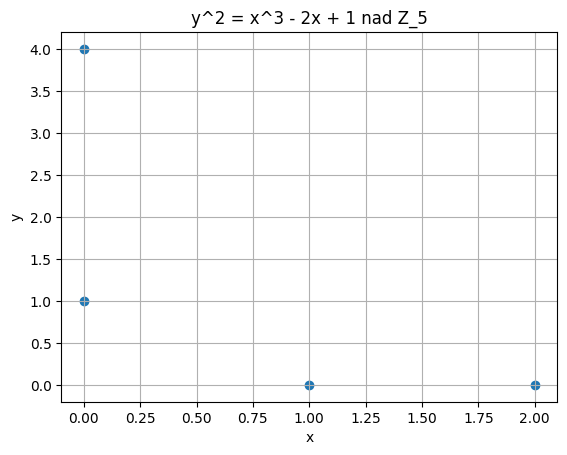

Analiza dla krzywej y^2 = x^3 - 2x + 1 nad Z_5
Punkt [0, 1] generuje grupę: [[0, 1], [1, 0], [0, 4], ['∞']], długość grupy: 4
Punkt [0, 4] generuje grupę: [[0, 4], [1, 0], [0, 1], ['∞']], długość grupy: 4
Punkt [1, 0] generuje grupę: [[1, 0], ['∞']], długość grupy: 2
Punkt [2, 0] generuje grupę: [[2, 0], ['∞']], długość grupy: 2


In [49]:
# Krzywe do analizy
curves = [
    {"a": -1, "b": 0, "p": 7, "title": "y^2 = x^3 - x nad Z_7"},
    {"a": -2, "b": 1, "p": 5, "title": "y^2 = x^3 - 2x + 1 nad Z_5"}
]

# Iteracja przez każdą krzywą
for curve in curves:
    a, b, p = curve["a"], curve["b"], curve["p"]
    points = gen(a, b, p)
    
    # Punkty na wykresie
    xs, ys = zip(*points)
    plt.scatter(xs, ys)
    plt.title(curve["title"])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()
    
    # Analiza grup generowanych przez punkty
    print(f"Analiza dla krzywej {curve['title']}")
    for P in points:
        group = [P]
        current = P
        
        while True:
            current = multiply(len(group) + 1, P, a, p)
            if np.isnan(current[0]):  # Punkt w nieskończoności
                break
            if current in group:
                break
            group.append(current)
        
        group.append(["∞"])  # Punkt w nieskończoności
        print(f"Punkt {P} generuje grupę: {group}, długość grupy: {len(group)}")

## Zadanie 4 (1 pkt)

Sprawdź numerycznie, korzystając z funkcji **gen()**, twierdzenie Hassego. Sprawdź, że ze wzrostem liczby pierwszej $p$ dla krzywej o parametrach $a=-1$, $b=0$ liczba punktów na krzywej podąża za oszacowaniem $p+1-2\sqrt{p}\leq\#E\leq p+1+2\sqrt{p}$. Narysuj wykres $\#E(p)$ i proste o równaniach $p+1-2\sqrt{p}$ oraz $p+1+2\sqrt{p}$.

Uwaga: Możesz wygenerować liczby pierwsze, np. w zakresie od 0 do 1000, za pomocą:

In [51]:
from sympy import primerange
primes = list(primerange(0,1000))

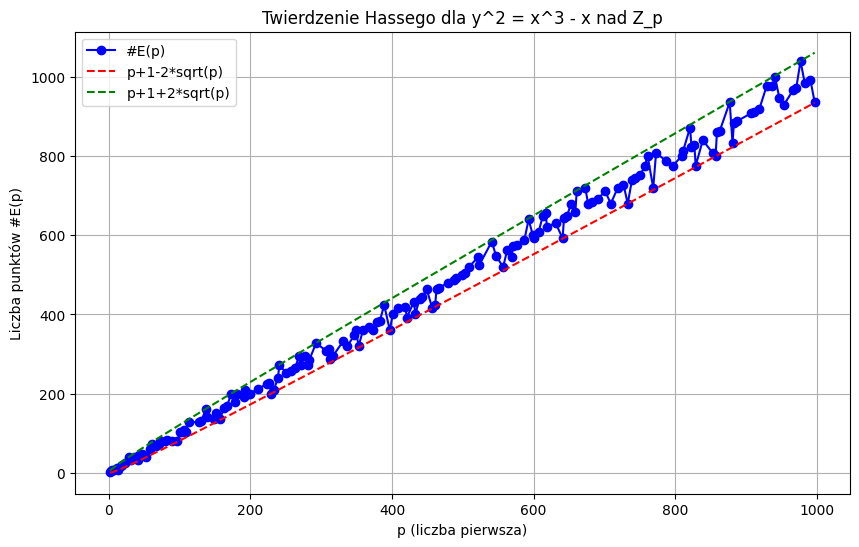

In [56]:
# Funkcja pomocnicza do obliczenia liczby punktów na krzywej
def count_points_on_curve(a, b, p):
    points = gen(a, b, p)
    return len(points) + 1  # Dodajemy punkt w nieskończoności

# Parametry krzywej
a, b = -1, 0

# Wyniki
p_values = []
point_counts = []
lower_bounds = []
upper_bounds = []

# Obliczenia dla każdego p
for p in primes:
    num_points = count_points_on_curve(a, b, p)
    lower_bound = p + 1 - 2 * np.sqrt(p)
    upper_bound = p + 1 + 2 * np.sqrt(p)

    p_values.append(p)
    point_counts.append(num_points)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

# Rysowanie wykresu
plt.figure(figsize=(10, 6))
plt.plot(p_values, point_counts, label="#E(p)", marker='o', linestyle='-', color='blue')
plt.plot(p_values, lower_bounds, label="p+1-2*sqrt(p)", linestyle='--', color='red')
plt.plot(p_values, upper_bounds, label="p+1+2*sqrt(p)", linestyle='--', color='green')

plt.xlabel("p (liczba pierwsza)")
plt.ylabel("Liczba punktów #E(p)")
plt.title("Twierdzenie Hassego dla y^2 = x^3 - x nad Z_p")
plt.legend()
plt.grid(True)
plt.show()

lub jakkolwiek inaczej.

## Zadanie 5 (2 pkt.)

Napisz funkcję **ord(G,a,p)** znajdującą rząd punktu $G$ na krzywej o parametrach $a$, $p$ (oznaczenia jak w poprzednich zadaniach). Rząd elementu to $n$ takie, że $nG=\mathcal{O}$. Znajdź punkt na krzywej o parametrach $a=-1$,$b=0$,$p=97$ o największym rzędzie, moze ich być więcej niż jeden, wybierz którykolwiek.

In [57]:
def ord(G,a,p):
    group = [G]
    current = G
    
    while True:
        current = multiply(len(group) + 1, G, a, p)
        if np.isnan(current[0]):  # Punkt w nieskończoności
            break
        if current in group:
            break
        group.append(current)
    group.append(["∞"])  # Punkt w nieskończoności
    return len(group)
    

In [58]:
print(ord([4,4],-1,11)==3)
print(ord([8,8],-1,11)==6)
print(ord([3,2],-1,7)==3)
print(ord([3,5],-1,7)==3)
print(ord([3,2],0,5)==3)
print(ord([0,0],0,5)==2)

True
True
True
True
True
True


In [63]:
max_val = 0
max_point = []
for point in gen(a=-1, b=0, p=97):
    val = ord(point,-1,97)
    if val > max_val:
        max_val = val
        max_point = point
print("Max order:", max_val, "\nfor point:", max_point)

Max order: 20 
for point: [6, 4]


## Zadanie 6 (1 pkt)

Prześledź działanie protokołu Diffiego-Helmana, jednak tym razem opertego o krzywe eliptyczne, i uzupełnij poszczególne kroki.

Alicja i Bob ustalają publicznie krzywą eliptyczą (czyli parametry $a$, $b$, $p$) w której będą działać oraz punkt na tej krzywej $G$. Weź krzywą z poprzedniego zadania oraz znaleziony w nim punkt.

In [64]:
a = -1
b = 0
G = [6, 4]
p = 97

Alicja wybiera losową liczbę naturalną $n$ z przedziału $[2,\#E-1]$, $\#E$ to liczba punktów na krzywej:

In [66]:
n=2

Następnie oblicza $A=nG$ zgodnie z zasadami mnożenia punktów na krzywej przez liczbe naturalną:

In [67]:
A=multiply(n, G, a, p)

To samo robi Bob, wybiera losową liczbę naturalną $m$ i oblicza $B=mG$:

In [68]:
m=3
B=multiply(m, G, a, p)

Liczby $n$ i $m$ są znane tylko, odpowiednio, Alicji i Bobowi, natomiast $A$ oraz $B$ są wymieniane publicznym kanałem. Bob otrzymuje $A$ i wykonuje operację $k_B=mA$, z kolei Alicja otrzymuje $B$ i wykonuje operację $k_A=nB$:

In [69]:
k_B=multiply(m, A, a, p)
k_A=multiply(n, B, a, p)

In [70]:
k_A==k_B

True

Zawuażmy, że $k_A=k_B$, wynika to z tego, że $k_A=nB=nmG$ oraz $k_B=mA=mnG$ a oczywiście $nm=mn$. Zatem Alicja i Bob dysponują tą samą liczbą, którą mogą użyć jako klucz do szyfrowania. Publicznie znane są wartości $a$, $b$, $p$, $G$, $nG$ oraz $mG$, jednak odzyskanie z nich $n$ i $m$ jest bardzo trudne przy odpwiednim doborze krzywej i punktu na niej.